# 1) Se cargan las librerias necesarias

In [37]:
# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd
import warnings

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Selección, validación de modelos y técnicas de balanceo de clases
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np




# 2) Carga y visualización de la base de datos

In [38]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')
warnings.filterwarnings('ignore')

In [39]:
# Numero de filas y columnas
medical_appointments.shape

(110527, 14)

In [40]:
# Encabezados
medical_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [41]:
# Numero de valores unicos por columna
column_counts = medical_appointments.nunique()
print(column_counts)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


In [42]:
# Tipo de datos
data_types = medical_appointments.dtypes
print(data_types)

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


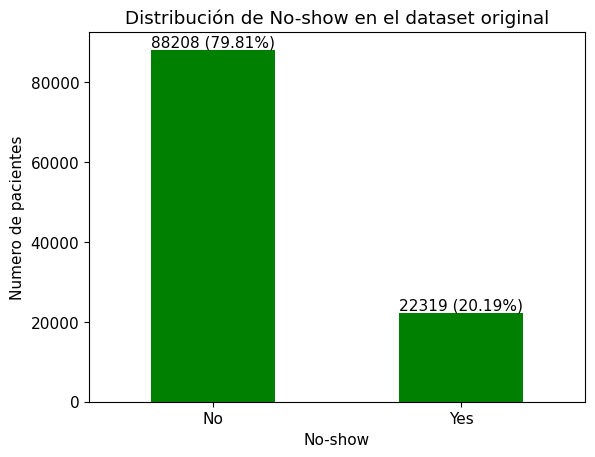

In [43]:
# Distribución del dataset original
class_counts = medical_appointments['No-show'].value_counts()
class_counts.plot(kind='bar', rot=0, color=['green'])
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset original')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

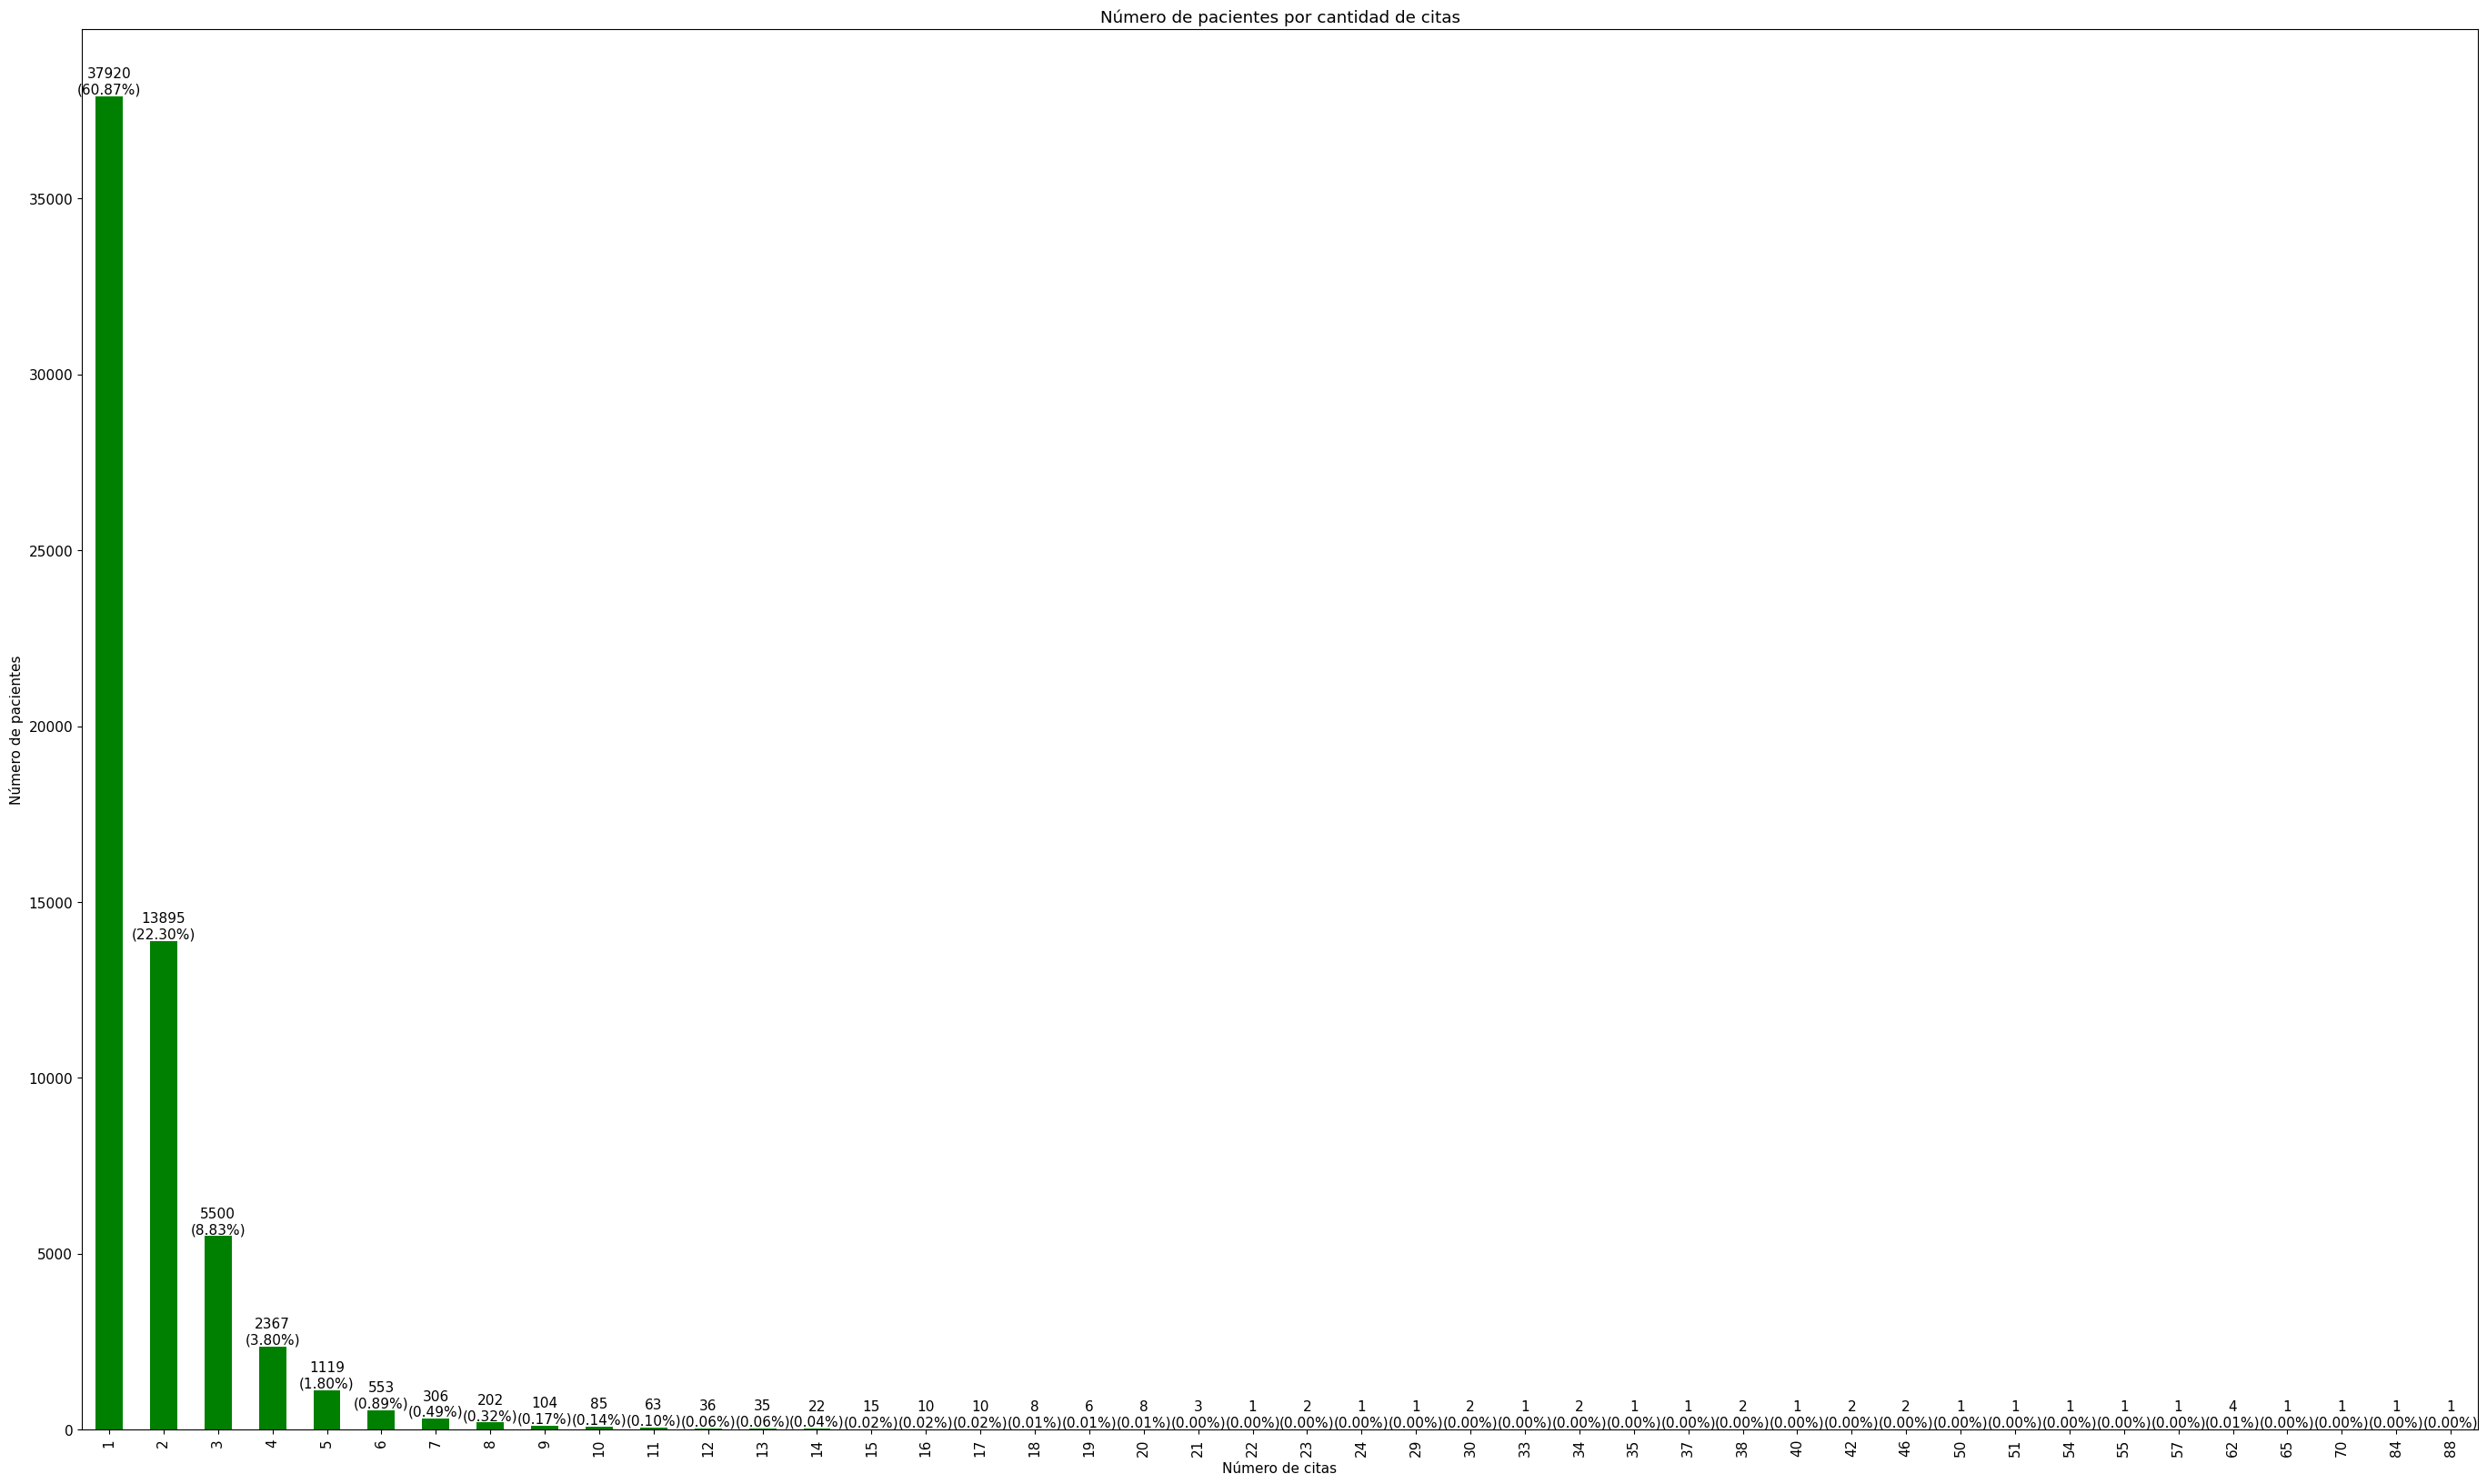

In [44]:
# Numero de citas por paciente
appointment_counts = medical_appointments['PatientId'].value_counts()

# Crear una serie que cuente cuántos pacientes tienen X número de citas
appointment_counts_summary = appointment_counts.value_counts().sort_index()

# Se modifica el tamaño de la figura
plt.figure(figsize=(34,20))

# Se modifica el tamaño de la fuente
plt.rcParams.update({'font.size': 11})

# Graficar la distribución
appointment_counts_summary.plot(kind='bar', color='green')
plt.xlabel('Número de citas')
plt.ylabel('Número de pacientes')
plt.title('Número de pacientes por cantidad de citas')

# Agregar texto sobre cada barra para mostrar el conteo y el porcentaje
for i, count in enumerate(appointment_counts_summary):
    percentage = count / len(appointment_counts) * 100
    plt.text(i, count, f'{count}\n({percentage:.2f}%)', ha='center', va='bottom')

# Muestra el gráfico
plt.show()


In [45]:
# Evaluar presencia de Missing values
missing_values = medical_appointments.isnull().sum()
print(missing_values)

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


# 3) Feature Engeniering

In [46]:
# Se crea una copia del dataset original
medical_appointments_transformed = medical_appointments.copy()

# Transformar las fechas a formato datetime
medical_appointments_transformed['ScheduledDay'] = pd.to_datetime(medical_appointments_transformed['ScheduledDay'])
medical_appointments_transformed['AppointmentDay'] = pd.to_datetime(medical_appointments_transformed['AppointmentDay'])

# Se ordena el dataframe por el id del paciente y la fecha de la cita
medical_appointments_transformed.sort_values(by=['PatientId', 'ScheduledDay'], inplace=True)

# Se calcula el tiempo en segundos entre la fecha de la cita y la fecha de programación
medical_appointments_transformed['Time_Before_Appointment'] = (medical_appointments_transformed['AppointmentDay'] - medical_appointments_transformed['ScheduledDay']).dt.total_seconds()

# Se agrega el día de la semana de la cita
medical_appointments_transformed['Appointment_DayOfWeek'] = medical_appointments_transformed['AppointmentDay'].dt.day_name()

# Se calcula el tiempo en días desde la última cita de cada paciente
medical_appointments_transformed['Days Since Last Appointment'] = medical_appointments_transformed.groupby('PatientId')['ScheduledDay'].diff().dt.days

# Se asgina 0 a los pacientes que no tienen citas previas
medical_appointments_transformed['Days Since Last Appointment'].fillna(0, inplace=True)

# Se convierte de time a int
medical_appointments_transformed['ScheduledDay'] = medical_appointments_transformed['ScheduledDay'].dt.strftime('%Y%m%d').astype(int)
medical_appointments_transformed['AppointmentDay'] = medical_appointments_transformed['AppointmentDay'].dt.strftime('%Y%m%d').astype(int)

# Instanciar un nuevo LabelEncoder para cada columna categórica

gender_encoder = LabelEncoder()
neighbourhood_encoder = LabelEncoder()
no_show_encoder = LabelEncoder()
Appointment_DayOfWeek_encoder = LabelEncoder()

# Convertir las columnas categóricas a numéricas usando fit_transform
medical_appointments_transformed['Gender'] = gender_encoder.fit_transform(medical_appointments_transformed['Gender'])
medical_appointments_transformed['Neighbourhood'] = neighbourhood_encoder.fit_transform(medical_appointments_transformed['Neighbourhood'])
medical_appointments_transformed['No-show'] = no_show_encoder.fit_transform(medical_appointments_transformed['No-show'])
medical_appointments_transformed['Appointment_DayOfWeek'] = Appointment_DayOfWeek_encoder.fit_transform(medical_appointments_transformed['Appointment_DayOfWeek'])

# Visualizar los cambios
medical_appointments_transformed.head(10)



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment
100517,3.921784e+04,5751990,0,20160531,20160603,44,56,0,0,0,0,0,0,0,219799.0,0,0.0
105430,4.374176e+04,5760144,1,20160601,20160601,39,43,0,0,1,0,0,0,0,-51778.0,5,0.0
3950,9.377953e+04,5712759,0,20160518,20160518,33,10,0,0,0,0,0,0,0,-33149.0,5,0.0
73303,1.417242e+05,5637648,1,20160429,20160502,12,23,0,0,0,0,0,0,0,233184.0,1,0.0
73228,5.376153e+05,5637728,0,20160429,20160506,14,23,0,0,0,0,0,1,0,578403.0,0,0.0
54611,5.628261e+06,5680449,1,20160510,20160513,13,52,0,0,0,0,0,0,1,216102.0,0,0.0
40692,1.183186e+07,5718578,1,20160519,20160519,16,69,0,0,0,0,0,0,0,-34927.0,3,0.0
58616,2.263866e+07,5580835,0,20160414,20160503,22,35,0,0,0,0,0,1,0,1614990.0,4,0.0
88585,2.263866e+07,5715081,0,20160518,20160608,23,35,0,0,0,0,0,1,0,1765368.0,5,34.0
49826,5.216894e+07,5607220,0,20160420,20160517,28,39,0,0,0,0,0,0,0,2291865.0,4,0.0


In [47]:
#Se verifican los tipos de datos resultantes
data_types = medical_appointments_transformed.dtypes
print(data_types)

PatientId                      float64
AppointmentID                    int64
Gender                           int32
ScheduledDay                     int32
AppointmentDay                   int32
Age                              int64
Neighbourhood                    int32
Scholarship                      int64
Hipertension                     int64
Diabetes                         int64
Alcoholism                       int64
Handcap                          int64
SMS_received                     int64
No-show                          int32
Time_Before_Appointment        float64
Appointment_DayOfWeek            int32
Days Since Last Appointment    float64
dtype: object


# 3.1) Se divide el dataset en conjunto de entrenamiento y prueba
Para continuar el procesamiento

In [48]:
# Se divide el dataframe en conjuntos de entrenamiento y prueba de forma estratificada
test_idxs = medical_appointments_transformed.groupby('No-show').apply(lambda x: x.sample(frac=0.2, random_state=0)).index.get_level_values(1)

# Paso 2: Crear el conjunto de prueba utilizando los índices obtenidos
test_df = medical_appointments_transformed.loc[test_idxs]

# Paso 3: Crear el conjunto de entrenamiento excluyendo los índices del conjunto de prueba
train_df = medical_appointments_transformed.drop(test_idxs)


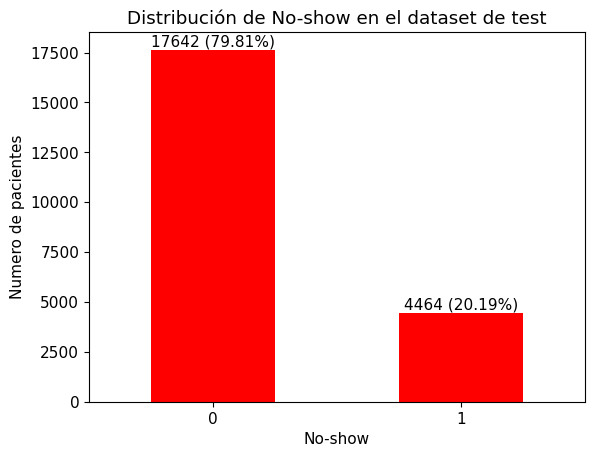

In [49]:
# Se verifican los conjunto de test resultante
class_counts_test = test_df['No-show'].value_counts()
class_counts_test.plot(kind='bar', rot=0, color='red')
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset de test')
for i, count in enumerate(class_counts_test):
    plt.text(i, count, f'{count} ({count / len(test_df) * 100:.2f}%)', ha='center', va='bottom')

# 3.2) Feature Engeniering parte 2: 
Se generan variables del dataset de entrenamiento: porcentaje de inasistencias de pacientes a sus citas, para no contaminar los datos de test, que son datos futuros y no contamos con esa información

In [50]:
# Calcular la suma acumulativa de inasistencias ('No-show' == 1) por PatientId
train_df['Cumulative No-shows'] = train_df.groupby('PatientId')['No-show'].transform('cumsum')

# Calcular el número acumulativo de citas por PatientId
train_df['Cumulative Appointments'] = train_df.groupby('PatientId').cumcount() + 1

# Calcular la probabilidad acumulativa de inasistencia por cita
train_df['Cumulative No-show Probability'] = train_df['Cumulative No-shows'] / train_df['Cumulative Appointments']

# Asignar un valor de 0 a la primera cita de cada paciente utilizando transform para mantener el índice
train_df['Cumulative No-show Probability'] = train_df.groupby('PatientId')['Cumulative No-show Probability'].transform(lambda x: x.shift().fillna(0))

# Se observan los cambios
train_df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment,Cumulative No-shows,Cumulative Appointments,Cumulative No-show Probability
100517,3.921784e+04,5751990,0,20160531,20160603,44,56,0,0,0,0,0,0,0,219799.0,0,0.0,0,1,0.0
105430,4.374176e+04,5760144,1,20160601,20160601,39,43,0,0,1,0,0,0,0,-51778.0,5,0.0,0,1,0.0
3950,9.377953e+04,5712759,0,20160518,20160518,33,10,0,0,0,0,0,0,0,-33149.0,5,0.0,0,1,0.0
73228,5.376153e+05,5637728,0,20160429,20160506,14,23,0,0,0,0,0,1,0,578403.0,0,0.0,0,1,0.0
54611,5.628261e+06,5680449,1,20160510,20160513,13,52,0,0,0,0,0,0,1,216102.0,0,0.0,1,1,0.0
40692,1.183186e+07,5718578,1,20160519,20160519,16,69,0,0,0,0,0,0,0,-34927.0,3,0.0,0,1,0.0
58616,2.263866e+07,5580835,0,20160414,20160503,22,35,0,0,0,0,0,1,0,1614990.0,4,0.0,0,1,0.0
88585,2.263866e+07,5715081,0,20160518,20160608,23,35,0,0,0,0,0,1,0,1765368.0,5,34.0,0,2,0.0
83628,5.216894e+07,5704816,0,20160516,20160516,28,39,0,0,0,0,0,0,0,-60139.0,1,26.0,0,1,0.0
46340,5.422400e+07,5613714,1,20160425,20160511,32,36,0,0,0,0,0,1,0,1347822.0,5,0.0,0,1,0.0


# 3.3) Se visualiza la correlación de datos

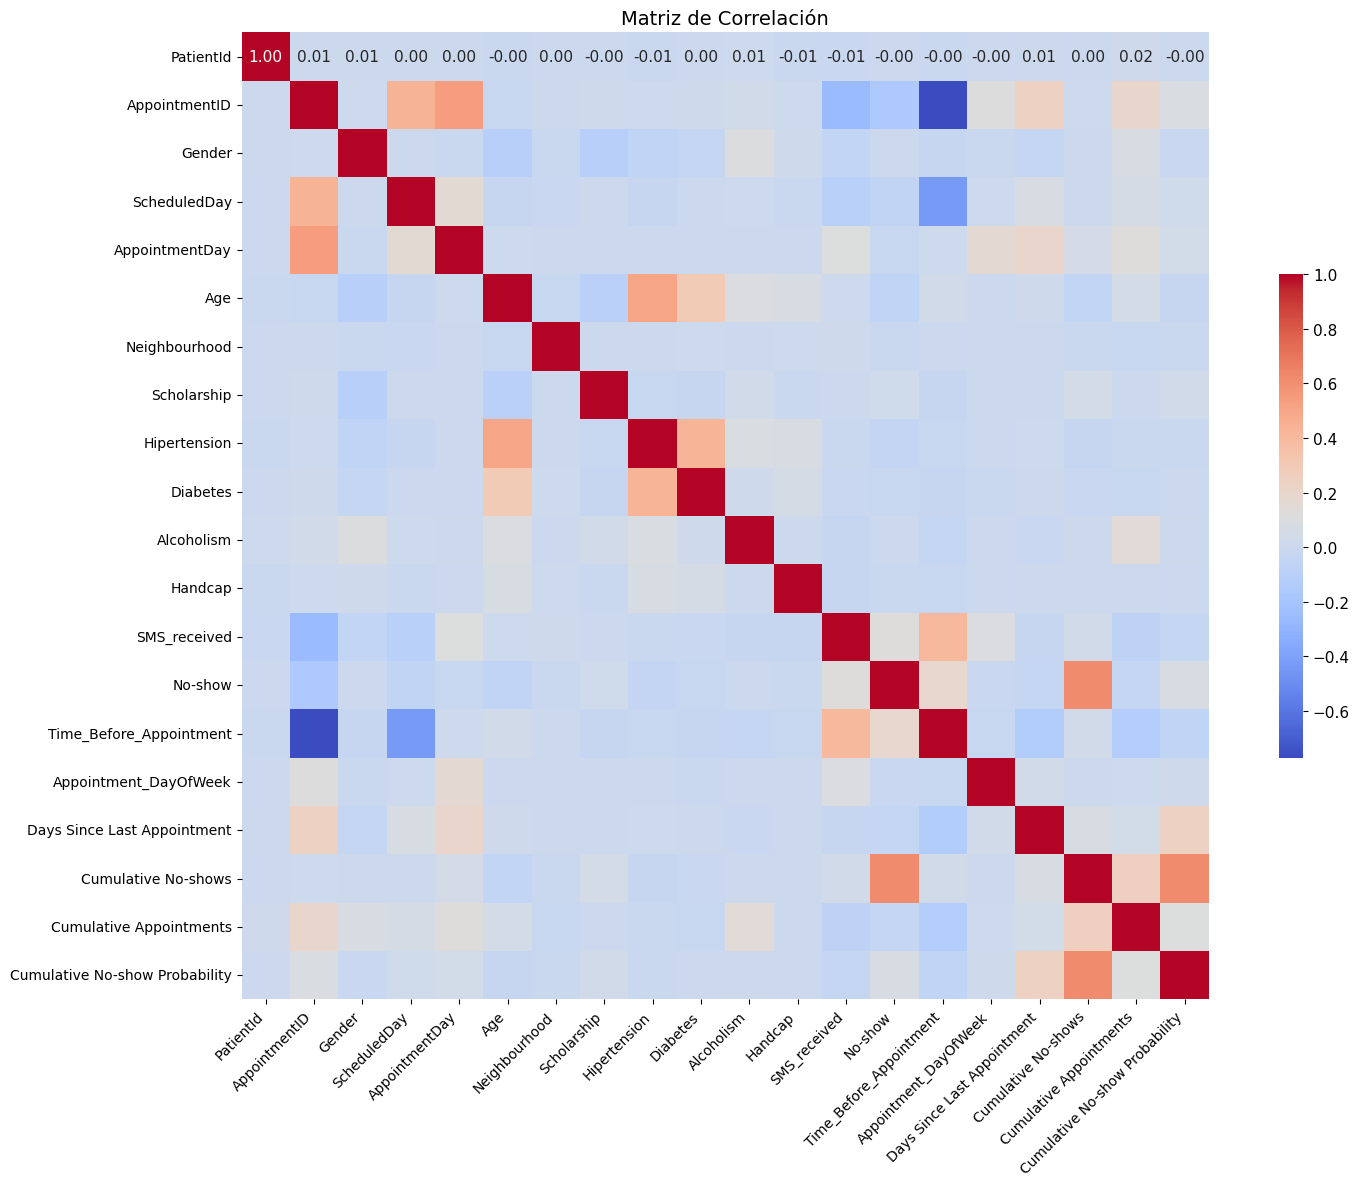

In [51]:
# Se calcula la matriz de correlación
corr = train_df.corr()
plt.figure(figsize=(16, 12))

# Crear el heatmap con números anotados
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': .5}, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns
)

plt.xticks(rotation=45, ha='right', size=10)  
plt.yticks(rotation=0, size=10)
plt.title('Matriz de Correlación', size=14)  
plt.tight_layout()
plt.show()



# 3.4) Se cruza la informacion con el dataset de test

In [52]:
# Se verifica que train_df y test_df sean valores del tipo
train_df['PatientId'] = train_df['PatientId'].astype(str)
test_df['PatientId'] = test_df['PatientId'].astype(str)

# Crear el DataFrame temporal, eliminando las filas duplicadas de 'PatientId'
temp_df = train_df[['PatientId', 'Cumulative No-show Probability', 'Cumulative Appointments', 'Cumulative No-shows']].drop_duplicates(subset='PatientId')

# Se realiza la unión de los DataFrames
test_df = test_df.merge(temp_df, on='PatientId', how='left')

# Imputación para los pacientes sin historial en train_df
test_df['Cumulative No-shows'].fillna(0, inplace=True)
test_df['Cumulative Appointments'].fillna(0, inplace=True)
test_df['Cumulative No-show Probability'].fillna(train_df['No-show'].mean(), inplace=True)

# Se observan los cambios
test_df.head(10)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment,Cumulative No-show Probability,Cumulative Appointments,Cumulative No-shows
0,758286294715.0,5650654,0,20160503,20160512,66,33,0,1,0,0,0,1,0,748893.0,3,0.0,0.201932,0.0,0.0
1,911594989391.0,5692028,0,20160512,20160519,43,75,0,0,0,0,0,0,0,553452.0,3,22.0,0.000000,1.0,0.0
2,6685555823843.0,5410963,0,20160301,20160502,74,38,0,0,0,0,0,1,0,5330289.0,1,0.0,0.000000,1.0,0.0
3,194877999558458.0,5654977,0,20160503,20160512,68,76,0,0,0,0,0,1,0,721226.0,3,1.0,0.000000,1.0,0.0
4,6879299542891.0,5683023,0,20160511,20160511,79,69,0,0,0,0,0,0,0,-25679.0,5,0.0,0.201932,0.0,0.0
5,643814388981185.0,5648958,0,20160502,20160516,0,77,0,0,0,0,0,0,0,1147858.0,1,0.0,0.000000,1.0,0.0
6,81364641647845.0,5578984,0,20160413,20160504,43,39,0,0,0,0,0,1,0,1763817.0,5,0.0,0.000000,1.0,0.0
7,6783416114778.0,5717953,1,20160519,20160519,17,76,0,0,0,0,0,0,0,-31199.0,3,5.0,0.000000,1.0,0.0
8,395476288231231.0,5728375,0,20160520,20160531,25,39,0,0,0,0,0,1,0,892178.0,4,38.0,0.000000,1.0,0.0
9,232235777468137.0,5542779,1,20160405,20160530,5,38,0,0,0,0,0,1,0,4718332.0,1,0.0,0.201932,0.0,0.0


# 3.5) Se elimina la información no relevante

In [53]:
# Se elimina la informacion que no es relevante
train_df = train_df.drop(['PatientId', 'AppointmentID'], axis=1)
test_df = test_df.drop(['PatientId', 'AppointmentID'], axis=1)

# Se verifican dimensiones de los conjuntos de datos
train_df.shape, test_df.shape
print(train_df.shape, test_df.shape)

(88421, 18) (22106, 18)


# 3.6) Se divide el conjunto de entrenamiento en características y etiquetas

In [54]:
# Se divide el conjunto de entrenamiento en características y etiquetas
X_train = train_df.drop('No-show', axis=1)
y_train = train_df['No-show']
X_test = test_df.drop('No-show', axis=1)
y_test = test_df['No-show']

# 4) Se Estandarizan las bases de datos

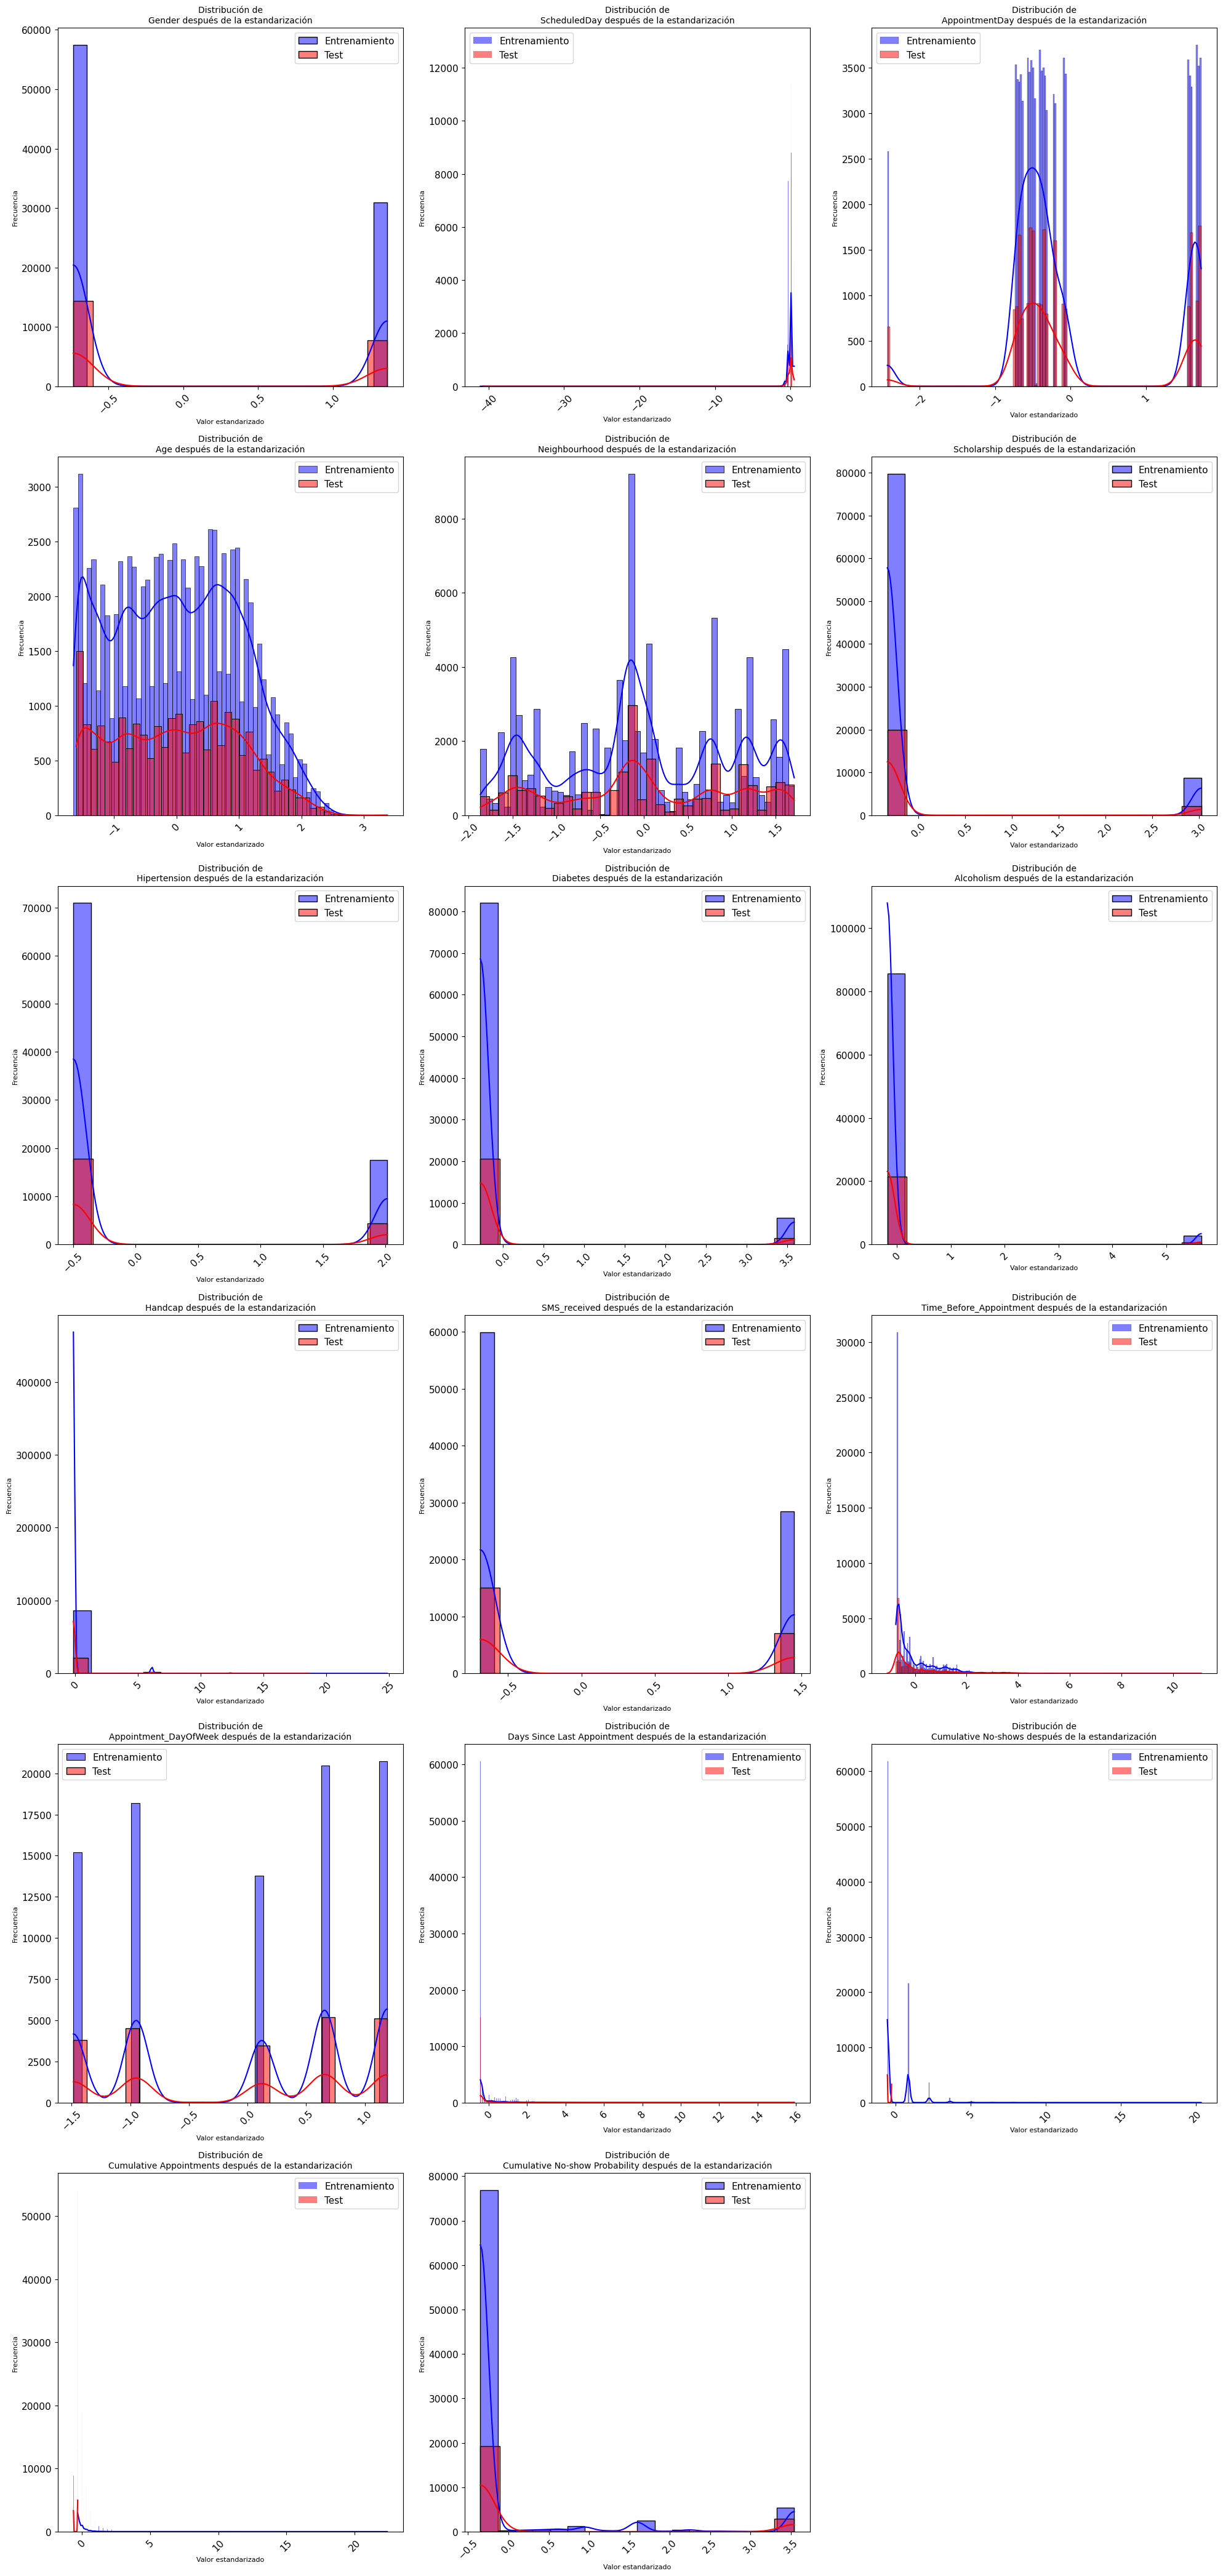

In [55]:
# Guardar los nombres de las columnas
column_names = X_train.columns

# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos de entrenamiento y se transforman
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Se transforman los datos de test utilizando el mismo escalador que se ajustó a los datos de entrenamiento

# Convertir los resultados a DataFrame para facilitar la manipulación y visualización
X_train_df = pd.DataFrame(X_train_scaled, columns=column_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=column_names) 

# Número de características en el DataFrame
num_features = X_train_df.shape[1]

# Número de columnas para los subgráficos
num_columns = 3

# Calcular el número de filas basado en el número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)

# Crear una figura grande para acomodar todos los subgráficos
plt.figure(figsize=(20, 7 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)
    
    # Histograma de los datos de entrenamiento en azul
    sns.histplot(X_train_df.iloc[:, i], kde=True, color='blue', alpha=0.5, label='Entrenamiento')
    
    # Histograma de los datos de test en rojo
    sns.histplot(X_test_df.iloc[:, i], kde=True, color='red', alpha=0.5, label='Test')
    
    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{column_names[i]} después de la estandarización', fontsize=10)
    
    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45)
    plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


# 5) Se realiza balanceo de clases en el dataset de entrenamiento

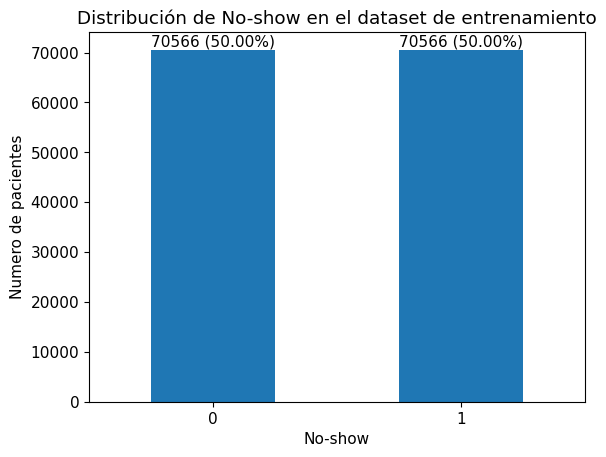

In [56]:
# Se crea una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Se aplica SMOTE a los datos
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Se aplica el pipeline a los datos
X_balanced_scaled, y_balanced = pipeline.fit_resample(X_train_scaled, y_train)

# Distribución del dataset posterior a la aplicación de SMOTE
class_counts = y_balanced.value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset de entrenamiento')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(X_balanced_scaled) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

# 6) Reduccion de dimensionalidad 

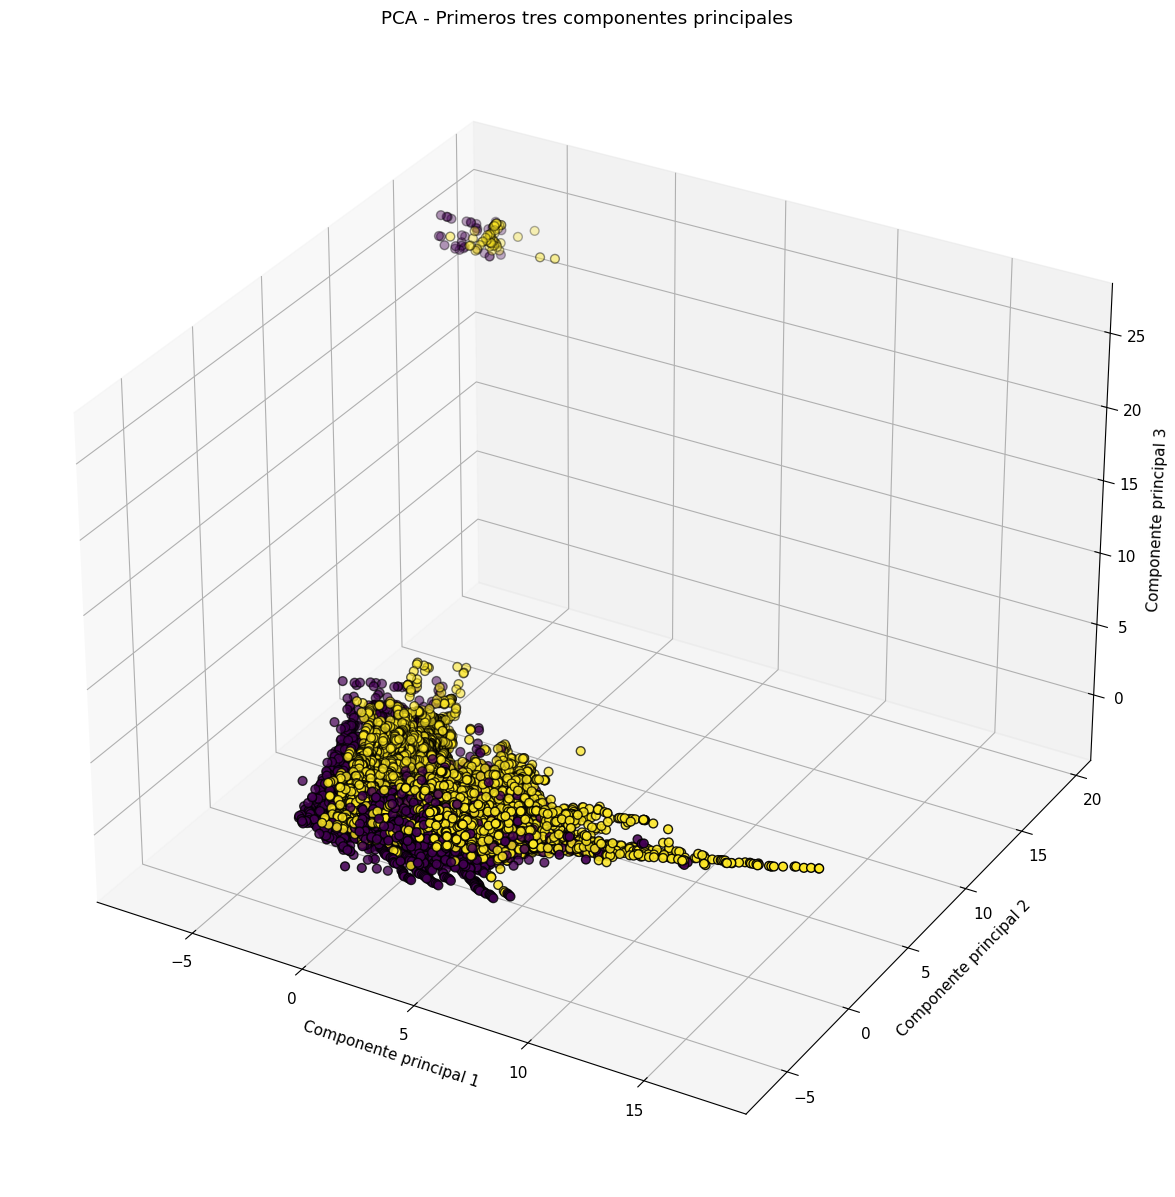

Número de componentes: 15
Varianza explicada por cada componente: [0.12602673 0.10663933 0.10182273 0.07731084 0.06766458 0.06247573
 0.0573403  0.05456588 0.05285678 0.05201151 0.04833331 0.04400726
 0.03712053 0.03533811 0.02775497]
Varianza total explicada: 0.9512686075228877


In [57]:
# Aplicar PCA para reducir la dimensionalidad mientras se conserva la mayor cantidad de varianza posible
pca = PCA(n_components=0.95) 

# Ajustar y transformar los datos de entrenamiento
X_balanced_scaled = pca.fit_transform(X_balanced_scaled)
X_test_scaled = pca.transform(X_test_scaled)

# Graficar los primeros tres componentes principales en un gráfico 3D
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_balanced_scaled[:, 0], X_balanced_scaled[:, 1], X_balanced_scaled[:, 2], c=y_balanced, cmap='viridis', edgecolor='k', s=40)
ax.set_title('PCA - Primeros tres componentes principales')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
plt.show()

# Imprimir la cantidad de componentes y la varianza explicada
print(f"Número de componentes: {pca.n_components_}")
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_)}")


# 7) Entrenamiento de modelos de Machine Learning:

In [58]:
#Se verifica la base de datos con las que se entrenará el modelo
X_balanced_scaled.shape, y_balanced.shape
# Se verifican los valores unicos de la variable objetivo en el dataset de entrenamiento
y_balanced.value_counts()

No-show
0    70566
1    70566
Name: count, dtype: int64

In [59]:
# Se verifica la base de datos con las que se testeara el modelo
X_test_scaled.shape, y_test.shape
# Se verifican los valores unicos de la variable objetivo en el dataset de test
y_test.value_counts()


No-show
0    17642
1     4464
Name: count, dtype: int64

In [60]:
# Se define un peso para las clases segun la distribución de las mismas en el dataset de test
class_counts_test = y_test.value_counts()
peso_clase_mayoritaria = class_counts_test[1] / len(y_test)
peso_clase_minoritaria = class_counts_test[0] / len(y_test)
class_weight = {0: peso_clase_mayoritaria, 1: peso_clase_minoritaria}
print (class_weight)

{0: 0.2019361259386592, 1: 0.7980638740613408}


In [61]:
# Se crea una función para evaluar los modelos de clasificación
def evaluar_modelo(grid_search, X_train, y_train, X_test, y_test):

    labels = ['Asiste', 'No-show']
    # Se obtienen los mejores parámetros y el mejor modelo
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Se calcula la predicción del modelo en el conjunto de entrenamiento con validación cruzada
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_score_train = f1_score(y_train, y_pred_train)
    
    print(f"Mejores parámetros encontrados: {best_params}")
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento con validación cruzada:") + '\n' + "Resultados datos de entrenamiento con validación cruzada:" + '\033[0m')
    print("Accuracy: (Validación cruzada datos train)", accuracy_train)
    print("Precision: (Validación cruzada datos train)", precision_train)
    print("Recall: (Validación cruzada datos train)", recall_train)
    print("F1 Score: (Validación cruzada datos train)", f1_score_train)

    # Hacer predicciones con el mejor modelo en el conjunto de train
    confusion_mat_train = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(confusion_mat_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusión (datos de train)')
    plt.xlabel('Valor Predicho')
    plt.ylabel('Valor Real')
    plt.show()
    print (confusion_mat_train)

    # Hacer predicciones con el mejor modelo en el conjunto de test
    y_pred_test = best_model.predict(X_test)

    # Calcular y presentar las métricas de evaluación para los datos de test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test)

    print('\033[1m' + '.' * len("Resultados datos de test con el mejor modelo:") + '\n' + "Resultados datos de test con el mejor modelo:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}") 
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_score_test:}")

    # Crear y visualizar la matriz de confusión para los datos de test
    confusion_mat_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusión (datos de test)')
    plt.xlabel('Valor Predicho')
    plt.ylabel('Valor Real')
    plt.show()
    print (confusion_mat_test)

   

7.1 Entrenamiento Regresión Logisitica

Mejores parámetros encontrados: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}
.........................................................
Resultados datos de entrenamiento con validación cruzada:
Accuracy: (Validación cruzada datos train) 0.8759671796615934
Precision: (Validación cruzada datos train) 0.8046366360849246
Recall: (Validación cruzada datos train) 0.9930419748887567
F1 Score: (Validación cruzada datos train) 0.8889664140052648


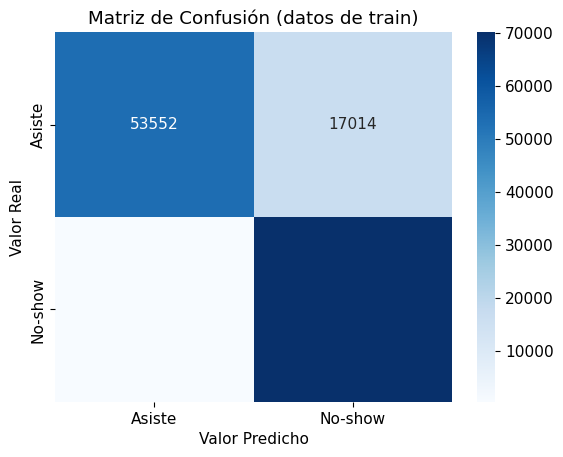

[[53552 17014]
 [  491 70075]]
.............................................
Resultados datos de test con el mejor modelo:
Accuracy (Datos de Test): 0.6953315841852891
Precision (Datos de Test): 0.31027568922305765
Recall (Datos de Test): 0.415994623655914
F1 Score (Datos de Test): 0.35544071202985933


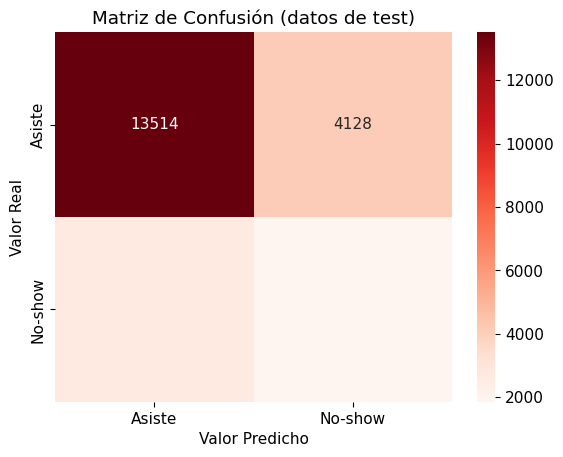

[[13514  4128]
 [ 2607  1857]]


In [62]:
# Diccionario de parámetros a probar extendiendo el espacio de búsqueda
param_grid = {
    'max_iter': [1000, 2000, 3000, 4000, 5000], # Número máximo de iteraciones
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], # Inversa del término de regularización, sirve para controlar el sobreajuste
    'penalty': ['l2'], # Tipo de regularización, 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # Algoritmo a utilizar en el problema de optimización
}

# Crear una instancia de GridSearchCV optimizada para la precisión
grid_search = GridSearchCV(LogisticRegression(class_weight=class_weight), param_grid, cv=5, scoring='precision', n_jobs=-1) 

# Ajustar GridSearchCV
grid_search.fit(X_balanced_scaled, y_balanced)

# Guardar el mejor modelo
best_model_logistic_regresion = grid_search.best_estimator_

# Evaluar el modelo
evaluar_modelo(grid_search, X_balanced_scaled, y_balanced, X_test_scaled, y_test)


7.2 Entrenamiento de DecisionTreeClassifier

Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
.........................................................
Resultados datos de entrenamiento con validación cruzada:
Accuracy: (Validación cruzada datos train) 0.9829733866167842
Precision: (Validación cruzada datos train) 0.9796090682652931
Recall: (Validación cruzada datos train) 0.9864807414335516
F1 Score: (Validación cruzada datos train) 0.9830328962697791


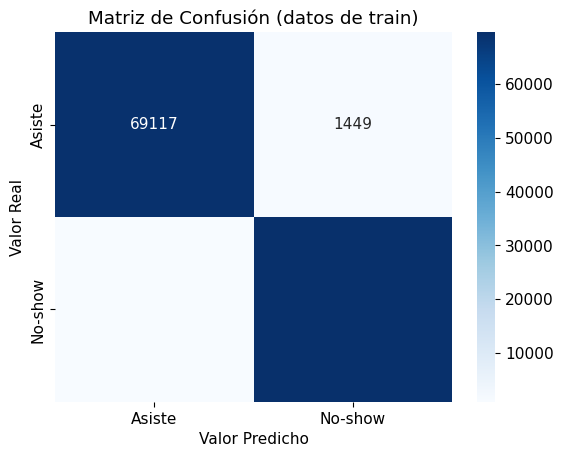

[[69117  1449]
 [  954 69612]]
.............................................
Resultados datos de test con el mejor modelo:
Accuracy (Datos de Test): 0.7967067764407854
Precision (Datos de Test): 0.3584905660377358
Recall (Datos de Test): 0.008512544802867384
F1 Score (Datos de Test): 0.01663019693654267


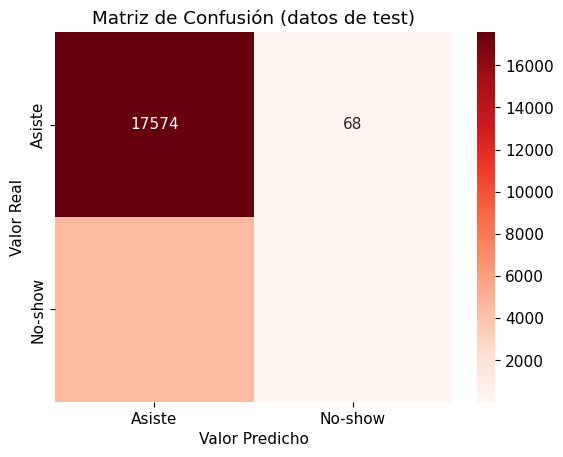

[[17574    68]
 [ 4426    38]]


In [63]:
# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50], # Profundidad máxima del árbol
    'min_samples_split': [2, 3, 5, 10], # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4], # Número mínimo de muestras requeridas en cada nodo hoja
    'criterion': ['gini', 'entropy'] # Función para medir el grado de impureza de un nodo
}

# Crear una instancia de GridSearchCV, optimizada para la precisión
grid_search = GridSearchCV(DecisionTreeClassifier(class_weight=class_weight), param_grid, cv=5, scoring='precision', n_jobs=-1)

# Ajustar GridSearchCV a los datos
grid_search.fit(X_balanced_scaled, y_balanced)

# Guardar el mejor modelo
best_model_tree = grid_search.best_estimator_

# Evaluar el modelo
evaluar_modelo (grid_search, X_balanced_scaled, y_balanced, X_test_scaled, y_test)

7.3 Entrenamiento de Support Vector Machine

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros encontrados: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
.........................................................
Resultados datos de entrenamiento con validación cruzada:
Accuracy: (Validación cruzada datos train) 0.9837669699288609
Precision: (Validación cruzada datos train) 0.9690054542706802
Recall: (Validación cruzada datos train) 0.9995040104299521
F1 Score: (Validación cruzada datos train) 0.9840184718840903


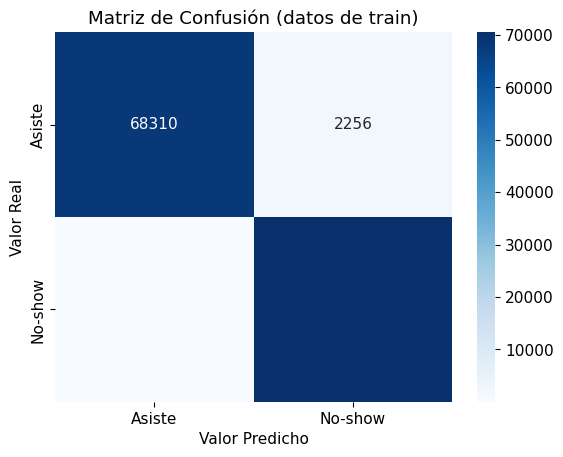

[[68310  2256]
 [   35 70531]]
.............................................
Resultados datos de test con el mejor modelo:
Accuracy (Datos de Test): 0.7980186374739889
Precision (Datos de Test): 0.4444444444444444
Recall (Datos de Test): 0.0008960573476702509
F1 Score (Datos de Test): 0.001788508830762352


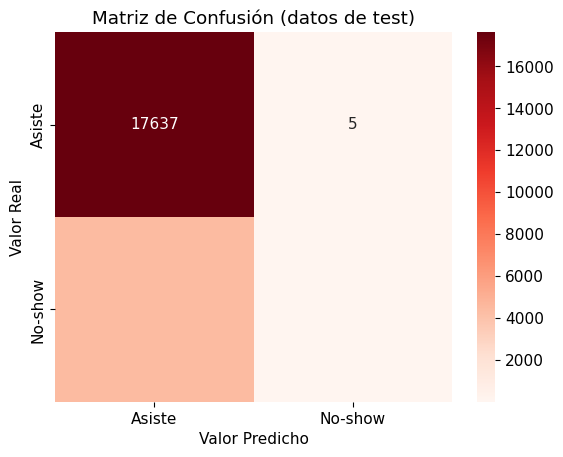

[[17637     5]
 [ 4460     4]]


In [64]:
# Crear una instancia de SVC
clf_svm = SVC(class_weight=class_weight)

# Diccionario de parámetros a probar
param_grid = {
    'C': [0.1, 1, 10],  # Parámetro de regularización, controla el sobreajuste
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel, permite separaciones no lineales
    'gamma': ['scale', 'auto'],  # Coeficiente de kernel para 'rbf', 'poly' y 'sigmoid', controla el sobreajuste
}

# Crear una instancia de GridSearchCV optimizada para la precisión
grid_search = GridSearchCV(clf_svm, param_grid, cv=5, scoring='precision', verbose=10, n_jobs=-1)

# Ajustar GridSearchCV
grid_search.fit(X_balanced_scaled, y_balanced)

# Guardar el mejor modelo
best_model_svm = grid_search.best_estimator_

# Evaluar el modelo
evaluar_modelo(grid_search, X_balanced_scaled, y_balanced, X_test_scaled, y_test)

7.4 Entrranamiento de red neuronal

Epoch [1/50], Loss: 2730.1147
Epoch [2/50], Loss: 4316.6606
Epoch [3/50], Loss: 2634.2349
Epoch [4/50], Loss: 2405.7703
Epoch [5/50], Loss: 5507.0322
Epoch [6/50], Loss: 669.5338
Epoch [7/50], Loss: 13377.0947
Epoch [8/50], Loss: 6411.5288
Epoch [9/50], Loss: 5154.5103
Epoch [10/50], Loss: 9157.1201
Epoch [11/50], Loss: 9944.8242
Epoch [12/50], Loss: 11717.1973
Epoch [13/50], Loss: 2560.6707
Epoch [14/50], Loss: 3301.9680
Epoch [15/50], Loss: 1218.8615
Epoch [16/50], Loss: 9353.2783
Epoch [17/50], Loss: 739.4409
Epoch [18/50], Loss: 4003.0811
Epoch [19/50], Loss: 3324.9409
Epoch [20/50], Loss: 8142.7212
Epoch [21/50], Loss: 11054.5439
Epoch [22/50], Loss: 8714.6943
Epoch [23/50], Loss: 591.9713
Epoch [24/50], Loss: 15503.9541
Epoch [25/50], Loss: 6280.4326
Epoch [26/50], Loss: 1938.1504
Epoch [27/50], Loss: 14482.9912
Epoch [28/50], Loss: 2009.9392
Epoch [29/50], Loss: 1936.6824
Epoch [30/50], Loss: 7518.5610
Epoch [31/50], Loss: 6719.3008
Epoch [32/50], Loss: 2773.6992
Epoch [33/50], 

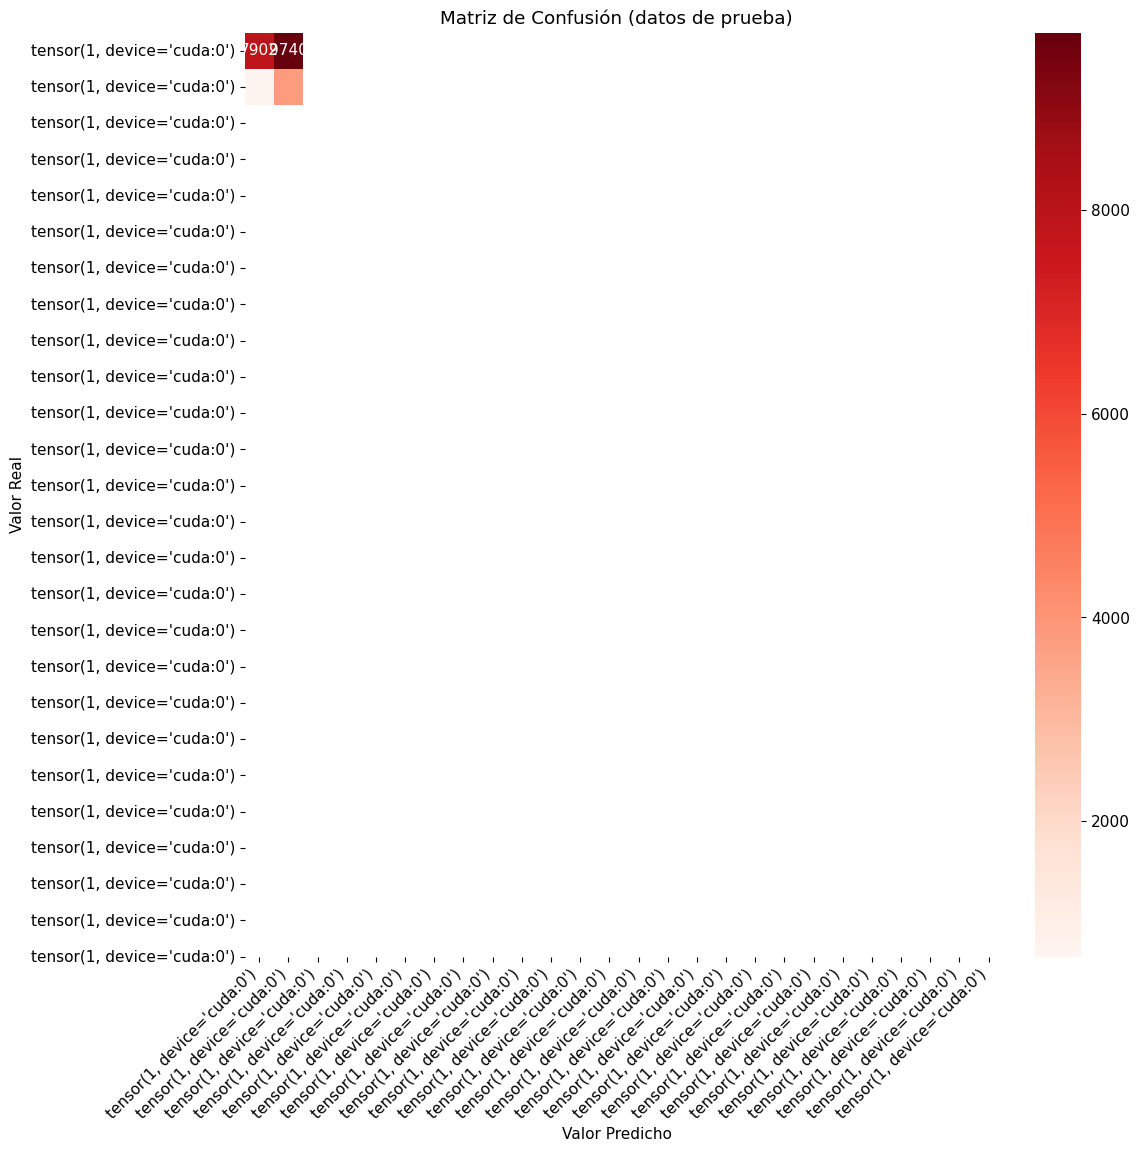

[[7902 9740]
 [ 671 3793]]


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


def evaluar_modelo_red_neuronal(modelo, train_loader, test_loader, device, labels):
    modelo.eval()  # Establecer el modelo en modo de evaluación

    # Evaluar en el conjunto de entrenamiento
    y_true_train, y_pred_train = [], []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

    accuracy_train = accuracy_score(y_true_train, y_pred_train)
    precision_train = precision_score(y_true_train, y_pred_train, average='weighted')
    recall_train = recall_score(y_true_train, y_pred_train, average='weighted')
    f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

    print("Resultados en el conjunto de entrenamiento:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print(f"Precision: {precision_train:.4f}")
    print(f"Recall: {recall_train:.4f}")
    print(f"F1 Score: {f1_train:.4f}")

    # Evaluar en el conjunto de prueba
    y_true_test, y_pred_test = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    accuracy_test = accuracy_score(y_true_test, y_pred_test)
    precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_true_test, y_pred_test, average='weighted')

    print("Resultados en el conjunto de prueba:")
    print(f"Accuracy: {accuracy_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Recall: {recall_test:.4f}")
    print(f"F1 Score: {f1_test:.4f}")

    # Crear y visualizar la matriz de confusión para los datos de prueba
    confusion_mat_test = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(12, 12))  # Aumenta el tamaño del gráfico para mejorar la legibilidad
    sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='Reds')
    plt.title('Matriz de Confusión (datos de prueba)')
    plt.xlabel('Valor Predicho')
    plt.ylabel('Valor Real')
    plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=45, ha='right')  # Rotar las etiquetas del eje x
    plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
    plt.show()
    print (confusion_mat_test)

# Se define la arquitectura de la red neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out


# Se preparan los datos para ser utilizados en la red neuronal
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # Tamaño del lote, número de ejemplos de entrenamiento utilizados en una iteración
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Se entrena la red neuronal 
input_size = X_train.shape[1]
hidden_size = 512  # Número de neuronas en la capa oculta
num_classes = len(torch.unique(y_train_tensor))
learning_rate = 0.0001 # Tasa de aprendizaje
num_epochs = 50  # Numero de epocas

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento de la red
model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward y optimizar
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
evaluar_modelo_red_neuronal(model, train_loader, test_loader, device, labels)




